In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip uninstall tensorflow
# !pip install tensorflow==2.2.0 tensorflow-gpu==2.2.0
# !pip install gensim==3.8.3

In [ ]:
import tensorflow as tf
tf.random.set_seed(1)
tf.compat.v1.enable_eager_execution()

import numpy as np
np.random.seed(1)

import gensim
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, \
    SpatialDropout1D, Bidirectional, Conv1D, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

%matplotlib inline

In [ ]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
df = pd.read_csv('drive/My Drive/NER/data/data.csv')

In [ ]:
df.head()

,word,tag
0,Pengamat,O
1,politik,O
2,dari,O
3,Universitas,B-ORGANIZATION
4,Gadjah,I-ORGANIZATION


In [ ]:
sentences = []
cnt = 1

for i in df.itertuples():
    sentences.append(cnt)
    
    if '.' in str(i.word):
        cnt += 1
        
df['sentence #'] = sentences
df.head()

,word,tag,sentence #
0,Pengamat,O,1
1,politik,O,1
2,dari,O,1
3,Universitas,B-ORGANIZATION,1
4,Gadjah,I-ORGANIZATION,1


In [ ]:
agg_func = lambda s: [(w, t) for w, t in zip(s['word'].values.tolist(), s['tag'].values.tolist())]
grouped = df.groupby('sentence #').apply(agg_func)
sentences = [s for s in grouped]

In [ ]:
words = list(set(df['word'].values))
words.append('PADDING')
num_words = len(words)
tags = list(set(df['tag'].values))
num_tags = len(tags)

In [ ]:
tags = sorted([t for t in tags if t != 'O'], key=lambda x: (x[2], x[0]))
tags.append('O')

In [ ]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
tag2idx

{'B-LOCATION': 0,
 'B-ORGANIZATION': 4,
 'B-PERSON': 8,
 'B-QUANTITY': 12,
 'B-TIME': 16,
 'I-LOCATION': 1,
 'I-ORGANIZATION': 5,
 'I-PERSON': 9,
 'I-QUANTITY': 13,
 'I-TIME': 17,
 'L-LOCATION': 2,
 'L-ORGANIZATION': 6,
 'L-PERSON': 10,
 'L-QUANTITY': 14,
 'L-TIME': 18,
 'O': 20,
 'U-LOCATION': 3,
 'U-ORGANIZATION': 7,
 'U-PERSON': 11,
 'U-QUANTITY': 15,
 'U-TIME': 19}

### Pad Sequence

In [ ]:
max_len = 60
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [ ]:
x_train, x_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=1)

### Pre-trained Word2Vec Embedding

In [ ]:
model = gensim.models.Word2Vec.load("drive/My Drive/NER/checkpoint/w2vec_wiki_id_case")

In [ ]:
embedding_matrix = np.zeros((len(words), 400))

for i, w in enumerate(words):
    try:
        embedding_vector = model.wv[w]
        embedding_matrix[i] = embedding_vector
    except:
        embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), 400)

Initial parameters

In [ ]:
params = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'lstm_units': 100,
    'filters': [128],
    'filter_size': [3],
    'dropout': 0.1,
    'batch_size': 128
}

In [ ]:
def get_report(model, history):
    # plot loss
    fig=plt.figure(figsize=(7,5))
    plt.plot(history.history['loss'], "-o")
    plt.plot(history.history['val_loss'], "-o")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylim(0,1)
    plt.show();
    
    print()
    # plot f1 score
    fig=plt.figure(figsize=(7,5))
    plt.plot(history.history['f1_score_micro'], "-o")
    plt.plot(history.history['val_f1_score_micro'], "-o")
    plt.title('f1_micro')
    plt.xlabel('epoch')
    plt.ylim(0,1)
    plt.show();
    
    print()
    # f1 score micro average
    actuals = np.argmax(np.array(y_test), axis=-1).reshape(-1)
    preds = model.predict(x_test)
    preds = np.argmax(preds, axis=-1).reshape(-1)

    score = f1_score(actuals, preds, average='micro')

    print('f1 score micro average include label O:', score)
    
    print()
    # print classification report
    print(classification_report(actuals, preds, target_names=tags, ))
    
    print()
    # f1 score micro average
    actuals = np.argmax(np.array(y_test), axis=-1).reshape(-1)
    preds = model.predict(x_test)
    preds = np.argmax(preds, axis=-1).reshape(-1)

    o_pad_idx = np.where(actuals==20)

    actuals = np.delete(actuals, o_pad_idx)
    preds = np.delete(preds, o_pad_idx)

    score = f1_score(actuals, preds, average='micro')

    print('f1 score micro average without label O:', score)
    
    print()
    # plot confusion matrix
    fig, ax = plt.subplots(figsize=(10,10))

    cm_matrix = confusion_matrix(actuals, preds)
    cm_matrix = np.delete(cm_matrix, (20), axis=0)
    cm_matrix = np.delete(cm_matrix, (20), axis=1)

    ax.matshow(cm_matrix, cmap=plt.cm.Blues)

    for i in range(num_tags-1):
        for j in range(num_tags-1):
            c = cm_matrix[j,i]
            ax.text(i, j, str(c), va='center', ha='center')

    plt.xticks(range(num_tags-1),['{} ({})'.format(tags[:-1][i],i) for i in range(num_tags-1)])
    plt.yticks(range(num_tags-1),['{} ({})'.format(tags[:-1][i],i) for i in range(num_tags-1)])
    plt.xticks(rotation=90)
    plt.show();

In [ ]:
def f1_score_micro(y_true, y_pred):
    y_true = np.argmax(y_true.numpy(), axis=-1).reshape(-1)
    y_pred = np.argmax(y_pred.numpy(), axis=-1).reshape(-1)
    
    # label O will be ignored during training and evaluation
    o_pad_idx = np.where(y_true==20) # 20 is the idx for label O
    
    # remove label O
    y_true = np.delete(y_true, o_pad_idx)
    y_pred = np.delete(y_pred, o_pad_idx)
    
    # compute f1 score with with micro average
    score = f1_score(y_true, y_pred, average='micro')
    
    return score

In [ ]:
def create_model(params, w2v=False, cnn=False):
    input_sequence = Input(shape=(max_len, ))
    
    # embedding layer
    if w2v:
        model = Embedding(
            input_dim= embedding_matrix.shape[0], 
            weights=[embedding_matrix], 
            output_dim=embedding_matrix.shape[1], 
            input_length=max_len,
            trainable=False
        )(input_sequence)
    else:
        model = Embedding(
            input_dim=num_words,
            output_dim=400,
            input_length=max_len,
        )(input_sequence)
    
    # dropout layer
    model = SpatialDropout1D(0.1)(model)
    
    # convolution layer
    if cnn:
        if len(params['filters']) == 1:
            model = Conv1D(params['filters'][0], params['filter_size'][0], activation='relu', padding='same')(model)
        else:
            cnns = []
            for i, _ in enumerate(params['filters']):
                cnns.append(Conv1D(
                    params['filters'][i], params['filter_size'][i], 
                    activation='relu', padding='same')(model))
            
            model = concatenate(cnns)
            
    # lstm layer
    model = Bidirectional(LSTM(units=100, return_sequences=True))(model)
    
    # output layer
    output_sequence = Dense(num_tags, activation='softmax')(model)
    
    # model
    model = Model(input_sequence, output_sequence)
    
    # learning algorithm (optimizer)
    if params['optimizer'] == 'Nadam':
        optm = tf.keras.optimizers.Nadam(lr=params['lr'])
        
    if params['optimizer'] == 'Adam':
        optm = tf.keras.optimizers.Adam(lr=params['lr'])
        
    if params['optimizer'] == 'RMSprop':
        optm = tf.keras.optimizers.RMSprop(lr=params['lr'])
    
    loss = tf.keras.losses.CategoricalCrossentropy()

    model.compile(loss=loss, optimizer=optm, metrics=[f1_score_micro], run_eagerly=True)
    
    return model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_f1_score_micro', mode='max')

### BiLSTM

In [ ]:
bilstm = create_model(params)

In [ ]:
bilstm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 400)           5212400   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 60, 400)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 200)           400800    
_________________________________________________________________
dense (Dense)                (None, 60, 21)            4221      
Total params: 5,617,421
Trainable params: 5,617,421
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time

bilstm_history = bilstm.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 4s 165ms/step - loss: 1.0158 - f1_score_micro: 0.0053 - val_loss: 0.3462 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 4s 166ms/step - loss: 0.3074 - f1_score_micro: 0.0000e+00 - val_loss: 0.2817 - val_f1_score_micro: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 4s 165ms/step - loss: 0.2650 - f1_score_micro: 0.0000e+00 - val_loss: 0.2540 - val_f1_score_micro: 0.0000e+00
Epoch 4/100
27/27 [==============================] - 4s 164ms/step - loss: 0.2331 - f1_score_micro: 1.2223e-04 - val_loss: 0.2298 - val_f1_score_micro: 3.5842e-04
Epoch 5/100
27/27 [==============================] - 4s 167ms/step - loss: 0.2048 - f1_score_micro: 0.0196 - val_loss: 0.2118 - val_f1_score_micro: 0.0502
Epoch 6/100
27/27 [==============================] - 4s 163ms/step - loss: 0.1822 - f1_score_micro: 0.1057 - val_loss: 0.1991 - val_f1_score_micro: 0.1384
Epoch 7/100
27/27 [=======================

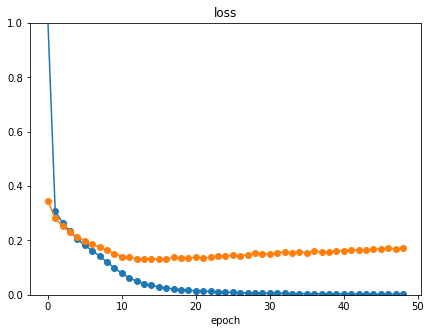

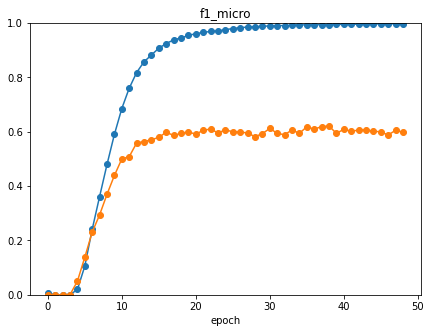


f1 score micro average include label O: 0.9726839237057221

                precision    recall  f1-score   support

    B-LOCATION       0.66      0.63      0.65       104
    I-LOCATION       0.59      0.34      0.43        77
    L-LOCATION       0.68      0.64      0.66       102
    U-LOCATION       0.75      0.69      0.72       238
B-ORGANIZATION       0.70      0.59      0.64       155
I-ORGANIZATION       0.76      0.50      0.60       139
L-ORGANIZATION       0.70      0.58      0.63       157
U-ORGANIZATION       0.82      0.73      0.77       251
      B-PERSON       0.86      0.66      0.75       229
      I-PERSON       0.62      0.48      0.55        62
      L-PERSON       0.83      0.63      0.72       230
      U-PERSON       0.83      0.80      0.82       261
    B-QUANTITY       0.58      0.44      0.50        59
    I-QUANTITY       0.59      0.37      0.45        52
    L-QUANTITY       0.50      0.46      0.48        54
    U-QUANTITY       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.6211180124223602



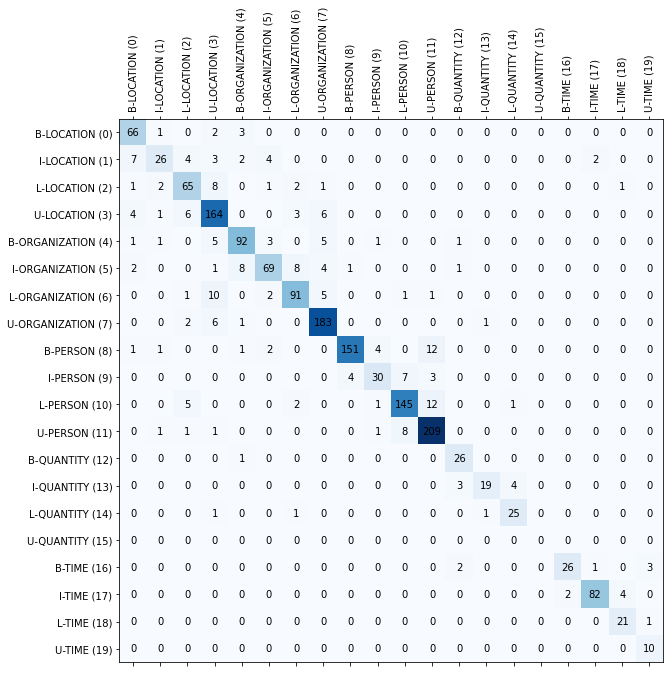

In [ ]:
get_report(bilstm, bilstm_history)

### BiLSTM + w2v

In [ ]:
bilstm_w2v = create_model(params, w2v=True)

In [ ]:
bilstm_w2v.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 400)           5212400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 60, 400)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 200)           400800    
_________________________________________________________________
dense_1 (Dense)              (None, 60, 21)            4221      
Total params: 5,617,421
Trainable params: 405,021
Non-trainable params: 5,212,400
_________________________________________________________________


In [ ]:
%%time

bilstm_w2v_history = bilstm_w2v.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 2s 78ms/step - loss: 0.5838 - f1_score_micro: 0.0044 - val_loss: 0.3114 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 2s 75ms/step - loss: 0.3018 - f1_score_micro: 4.5460e-04 - val_loss: 0.2878 - val_f1_score_micro: 0.0012
Epoch 3/100
27/27 [==============================] - 2s 74ms/step - loss: 0.2866 - f1_score_micro: 0.0016 - val_loss: 0.2769 - val_f1_score_micro: 0.0070
Epoch 4/100
27/27 [==============================] - 2s 74ms/step - loss: 0.2743 - f1_score_micro: 0.0084 - val_loss: 0.2650 - val_f1_score_micro: 0.0130
Epoch 5/100
27/27 [==============================] - 2s 74ms/step - loss: 0.2612 - f1_score_micro: 0.0160 - val_loss: 0.2522 - val_f1_score_micro: 0.0185
Epoch 6/100
27/27 [==============================] - 2s 74ms/step - loss: 0.2474 - f1_score_micro: 0.0202 - val_loss: 0.2397 - val_f1_score_micro: 0.0359
Epoch 7/100
27/27 [==============================] - 2s 74ms/step - 

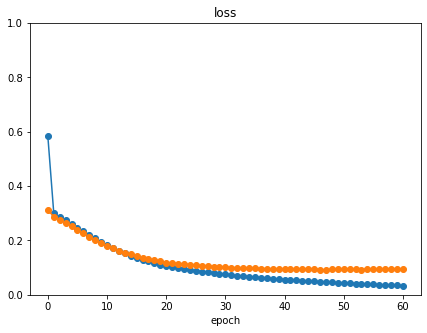

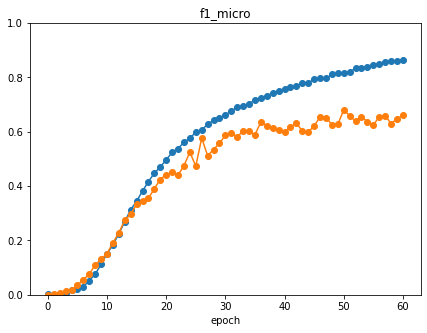


f1 score micro average include label O: 0.9731607629427793

                precision    recall  f1-score   support

    B-LOCATION       0.68      0.55      0.61       104
    I-LOCATION       0.68      0.49      0.57        77
    L-LOCATION       0.72      0.63      0.67       102
    U-LOCATION       0.74      0.79      0.77       238
B-ORGANIZATION       0.64      0.50      0.56       155
I-ORGANIZATION       0.48      0.41      0.44       139
L-ORGANIZATION       0.60      0.58      0.59       157
U-ORGANIZATION       0.76      0.61      0.67       251
      B-PERSON       0.84      0.80      0.82       229
      I-PERSON       0.58      0.68      0.63        62
      L-PERSON       0.85      0.80      0.83       230
      U-PERSON       0.84      0.80      0.82       261
    B-QUANTITY       0.53      0.42      0.47        59
    I-QUANTITY       0.74      0.27      0.39        52
    L-QUANTITY       0.49      0.41      0.44        54
    U-QUANTITY       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.643064182194617



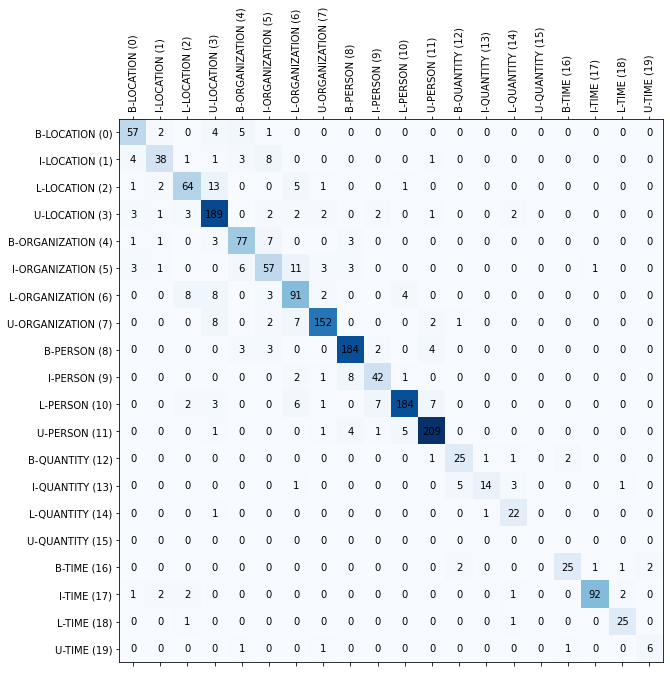

In [ ]:
get_report(bilstm_w2v, bilstm_w2v_history)

### BiLSTM-CNNs

In [ ]:
bilstm_cnns = create_model(params, cnn=True)

In [ ]:
bilstm_cnns.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 60, 400)           5212400   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 60, 400)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 128)           153728    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 200)           183200    
_________________________________________________________________
dense_2 (Dense)              (None, 60, 21)            4221      
Total params: 5,553,549
Trainable params: 5,553,549
Non-trainable params: 0
_________________________________________________

In [ ]:
%%time

bilstm_cnns_history = bilstm_cnns.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 5s 177ms/step - loss: 0.8757 - f1_score_micro: 9.7700e-04 - val_loss: 0.3097 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 4s 154ms/step - loss: 0.2951 - f1_score_micro: 0.0000e+00 - val_loss: 0.2761 - val_f1_score_micro: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 4s 156ms/step - loss: 0.2630 - f1_score_micro: 0.0000e+00 - val_loss: 0.2549 - val_f1_score_micro: 0.0000e+00
Epoch 4/100
27/27 [==============================] - 4s 154ms/step - loss: 0.2289 - f1_score_micro: 3.4413e-04 - val_loss: 0.2231 - val_f1_score_micro: 0.0091
Epoch 5/100
27/27 [==============================] - 4s 157ms/step - loss: 0.1859 - f1_score_micro: 0.0861 - val_loss: 0.2021 - val_f1_score_micro: 0.1332
Epoch 6/100
27/27 [==============================] - 4s 154ms/step - loss: 0.1526 - f1_score_micro: 0.2590 - val_loss: 0.1823 - val_f1_score_micro: 0.2291
Epoch 7/100
27/27 [=======================

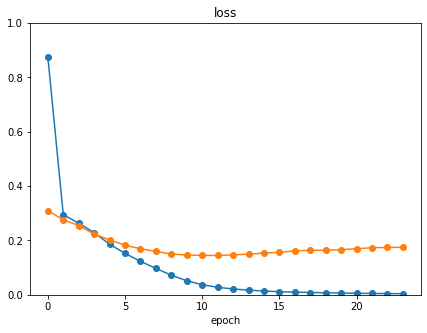

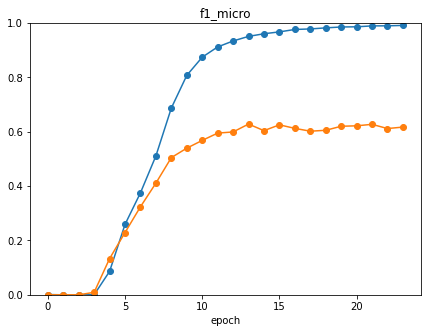


f1 score micro average include label O: 0.9706630336058129

                precision    recall  f1-score   support

    B-LOCATION       0.76      0.62      0.68       104
    I-LOCATION       0.48      0.34      0.40        77
    L-LOCATION       0.71      0.72      0.71       102
    U-LOCATION       0.77      0.68      0.72       238
B-ORGANIZATION       0.72      0.60      0.65       155
I-ORGANIZATION       0.75      0.47      0.58       139
L-ORGANIZATION       0.71      0.64      0.67       157
U-ORGANIZATION       0.83      0.70      0.76       251
      B-PERSON       0.82      0.66      0.73       229
      I-PERSON       0.67      0.56      0.61        62
      L-PERSON       0.81      0.62      0.70       230
      U-PERSON       0.84      0.83      0.83       261
    B-QUANTITY       0.28      0.36      0.31        59
    I-QUANTITY       0.25      0.31      0.28        52
    L-QUANTITY       0.27      0.48      0.35        54
    U-QUANTITY       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.6198757763975156



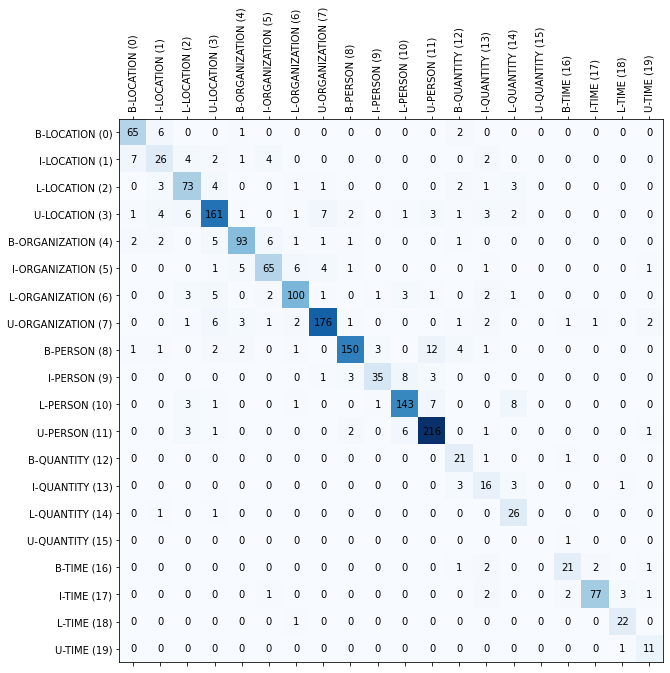

In [ ]:
get_report(bilstm_cnns, bilstm_cnns_history)

### BiLSTM-CNNs + w2v

In [ ]:
bilstm_cnns_w2v = create_model(params, w2v=True, cnn=True)

In [ ]:
bilstm_cnns_w2v.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 60, 400)           5212400   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 60, 400)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 128)           153728    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60, 200)           183200    
_________________________________________________________________
dense_3 (Dense)              (None, 60, 21)            4221      
Total params: 5,553,549
Trainable params: 341,149
Non-trainable params: 5,212,400
___________________________________________

In [ ]:
%%time

bilstm_cnns_w2v_history = bilstm_cnns_w2v.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 2s 78ms/step - loss: 0.6067 - f1_score_micro: 0.0022 - val_loss: 0.3183 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 2s 77ms/step - loss: 0.3069 - f1_score_micro: 0.0000e+00 - val_loss: 0.2869 - val_f1_score_micro: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 2s 77ms/step - loss: 0.2795 - f1_score_micro: 0.0011 - val_loss: 0.2650 - val_f1_score_micro: 0.0096
Epoch 4/100
27/27 [==============================] - 2s 77ms/step - loss: 0.2563 - f1_score_micro: 0.0134 - val_loss: 0.2416 - val_f1_score_micro: 0.0212
Epoch 5/100
27/27 [==============================] - 2s 76ms/step - loss: 0.2340 - f1_score_micro: 0.0239 - val_loss: 0.2218 - val_f1_score_micro: 0.0335
Epoch 6/100
27/27 [==============================] - 2s 78ms/step - loss: 0.2140 - f1_score_micro: 0.0451 - val_loss: 0.2049 - val_f1_score_micro: 0.0689
Epoch 7/100
27/27 [==============================] - 2s 79ms/ste

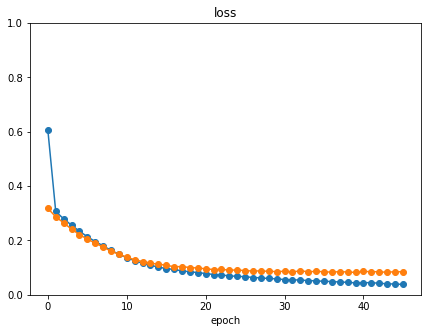

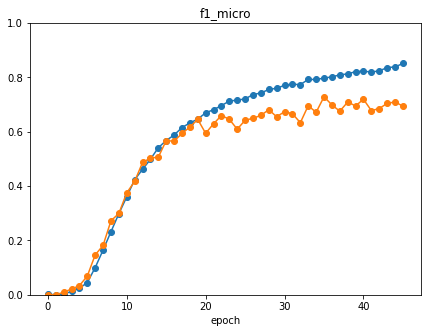


f1 score micro average include label O: 0.9751135331516803

                precision    recall  f1-score   support

    B-LOCATION       0.68      0.70      0.69       104
    I-LOCATION       0.59      0.52      0.55        77
    L-LOCATION       0.71      0.75      0.73       102
    U-LOCATION       0.79      0.81      0.80       238
B-ORGANIZATION       0.74      0.59      0.65       155
I-ORGANIZATION       0.69      0.48      0.57       139
L-ORGANIZATION       0.66      0.64      0.65       157
U-ORGANIZATION       0.74      0.56      0.64       251
      B-PERSON       0.87      0.87      0.87       229
      I-PERSON       0.52      0.74      0.61        62
      L-PERSON       0.85      0.86      0.85       230
      U-PERSON       0.82      0.84      0.83       261
    B-QUANTITY       0.51      0.34      0.41        59
    I-QUANTITY       0.66      0.37      0.47        52
    L-QUANTITY       0.73      0.41      0.52        54
    U-QUANTITY       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.6807453416149069



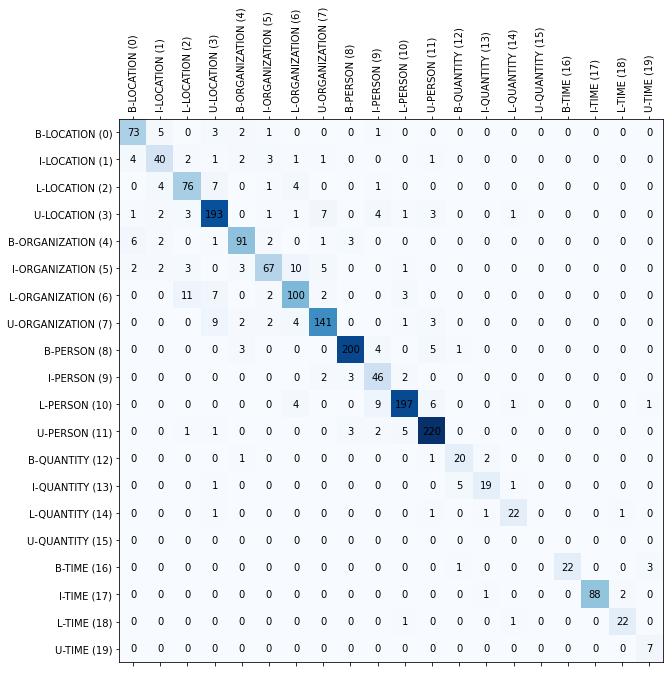

In [ ]:
get_report(bilstm_cnns_w2v, bilstm_cnns_w2v_history)

### BiLSTM-CNNs + multi-sequence n-gram

In [ ]:
multi_cnns_params = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'lstm_units': 100,
    'filters': [128, 128, 128, 128, 128],
    'filter_size': [2, 4, 6, 8, 10],
    'dropout': 0.5,
    'batch_size': 128
}

In [ ]:
bilstm_multi_cnns = create_model(multi_cnns_params, cnn=True)

In [ ]:
bilstm_multi_cnns.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 60, 400)      5212400     input_5[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_4 (SpatialDro (None, 60, 400)      0           embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 60, 128)      102528      spatial_dropout1d_4[0][0]        
____________________________________________________________________________________________

In [ ]:
%%time

bilstm_multi_cnns_history = bilstm_multi_cnns.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=multi_cnns_params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 7s 265ms/step - loss: 0.6266 - f1_score_micro: 0.0014 - val_loss: 0.3160 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 6s 223ms/step - loss: 0.2827 - f1_score_micro: 0.0000e+00 - val_loss: 0.2587 - val_f1_score_micro: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 6s 205ms/step - loss: 0.2297 - f1_score_micro: 0.0028 - val_loss: 0.2109 - val_f1_score_micro: 0.0252
Epoch 4/100
27/27 [==============================] - 5s 204ms/step - loss: 0.1703 - f1_score_micro: 0.1571 - val_loss: 0.1793 - val_f1_score_micro: 0.2448
Epoch 5/100
27/27 [==============================] - 6s 206ms/step - loss: 0.1251 - f1_score_micro: 0.3957 - val_loss: 0.1564 - val_f1_score_micro: 0.3655
Epoch 6/100
27/27 [==============================] - 6s 204ms/step - loss: 0.0869 - f1_score_micro: 0.5966 - val_loss: 0.1418 - val_f1_score_micro: 0.4694
Epoch 7/100
27/27 [==============================] - 6s 21

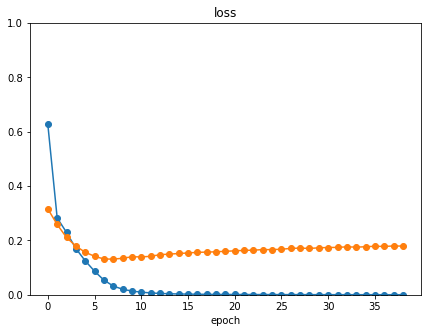

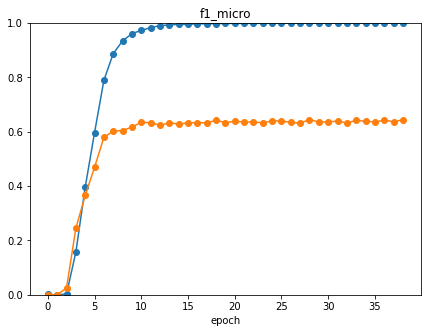


f1 score micro average include label O: 0.9728428701180745

                precision    recall  f1-score   support

    B-LOCATION       0.69      0.64      0.67       104
    I-LOCATION       0.46      0.39      0.42        77
    L-LOCATION       0.70      0.68      0.69       102
    U-LOCATION       0.79      0.69      0.74       238
B-ORGANIZATION       0.71      0.63      0.67       155
I-ORGANIZATION       0.73      0.50      0.59       139
L-ORGANIZATION       0.72      0.60      0.66       157
U-ORGANIZATION       0.79      0.75      0.77       251
      B-PERSON       0.86      0.69      0.77       229
      I-PERSON       0.73      0.60      0.65        62
      L-PERSON       0.83      0.65      0.73       230
      U-PERSON       0.82      0.83      0.82       261
    B-QUANTITY       0.39      0.32      0.35        59
    I-QUANTITY       0.45      0.46      0.46        52
    L-QUANTITY       0.40      0.46      0.43        54
    U-QUANTITY       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.643064182194617



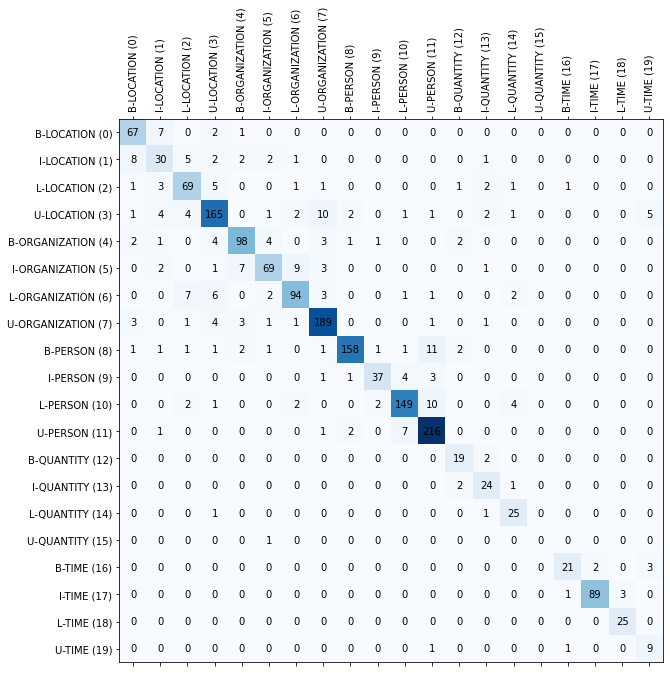

In [ ]:
get_report(bilstm_multi_cnns, bilstm_multi_cnns_history)

### BiLSTM-CNNs + multi-sequence n-gram + w2v

In [ ]:
bilstm_multi_cnns_w2v = create_model(multi_cnns_params, w2v=True, cnn=True)

In [ ]:
bilstm_multi_cnns_w2v.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 60, 400)      5212400     input_6[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 60, 400)      0           embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 60, 128)      102528      spatial_dropout1d_5[0][0]        
____________________________________________________________________________________________

In [ ]:
%%time

bilstm_multi_cnns_w2v_history = bilstm_multi_cnns_w2v.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=multi_cnns_params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 3s 117ms/step - loss: 0.4422 - f1_score_micro: 3.7890e-04 - val_loss: 0.2827 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 3s 117ms/step - loss: 0.2713 - f1_score_micro: 0.0038 - val_loss: 0.2510 - val_f1_score_micro: 0.0081
Epoch 3/100
27/27 [==============================] - 3s 117ms/step - loss: 0.2341 - f1_score_micro: 0.0282 - val_loss: 0.2149 - val_f1_score_micro: 0.0911
Epoch 4/100
27/27 [==============================] - 3s 116ms/step - loss: 0.1980 - f1_score_micro: 0.1012 - val_loss: 0.1876 - val_f1_score_micro: 0.1521
Epoch 5/100
27/27 [==============================] - 3s 117ms/step - loss: 0.1716 - f1_score_micro: 0.2090 - val_loss: 0.1662 - val_f1_score_micro: 0.2296
Epoch 6/100
27/27 [==============================] - 3s 117ms/step - loss: 0.1495 - f1_score_micro: 0.3015 - val_loss: 0.1495 - val_f1_score_micro: 0.2954
Epoch 7/100
27/27 [==============================] - 3s 117ms/

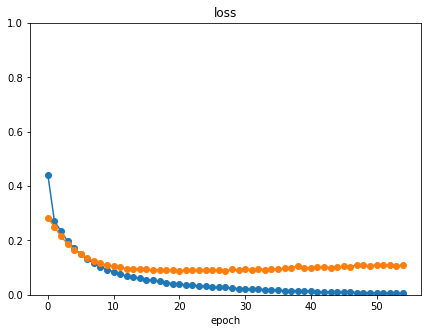

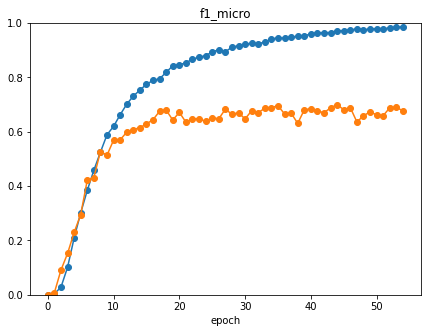


f1 score micro average include label O: 0.973819255222525

                precision    recall  f1-score   support

    B-LOCATION       0.70      0.63      0.67       104
    I-LOCATION       0.57      0.48      0.52        77
    L-LOCATION       0.69      0.71      0.70       102
    U-LOCATION       0.78      0.69      0.73       238
B-ORGANIZATION       0.70      0.56      0.62       155
I-ORGANIZATION       0.67      0.45      0.54       139
L-ORGANIZATION       0.66      0.62      0.64       157
U-ORGANIZATION       0.66      0.62      0.64       251
      B-PERSON       0.81      0.85      0.83       229
      I-PERSON       0.60      0.63      0.61        62
      L-PERSON       0.83      0.84      0.84       230
      U-PERSON       0.85      0.80      0.82       261
    B-QUANTITY       0.48      0.39      0.43        59
    I-QUANTITY       0.70      0.37      0.48        52
    L-QUANTITY       0.57      0.39      0.46        54
    U-QUANTITY       0.00      0.00      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.6567287784679089



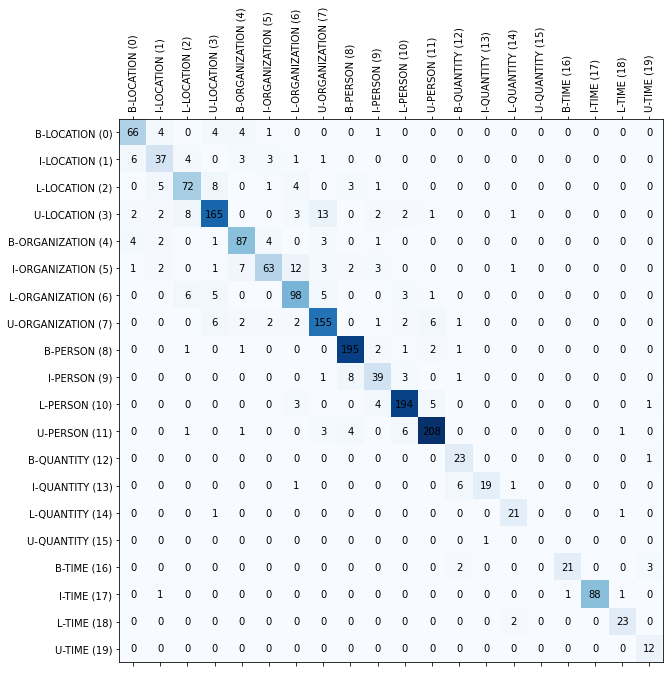

In [ ]:
get_report(bilstm_multi_cnns_w2v, bilstm_multi_cnns_w2v_history)